In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'ZEIT ONLINE',
    'Der Tagesspiegel',
    'ARD',
    'tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

search_terms = {
    'cdu':['cdu'],
    'csu':['csu'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

/Users/hs/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [36]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        #temp = [string.__contains__(p) for string in input_string.split()]
        temp = [string == p for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            #lower_bound = 0
            output_strings[i] = ""
        if upper_bound > len(input_string.split()):
            #upper_bound = len(input_string.split())
            output_strings[i] = ""
        else:
            output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_avg_sentiment_df(input_df):
    avg_pos = input_df[input_df['positive']].groupby(['medium'])['score'].median()
    avg_neu = input_df[input_df['neutral']].groupby(['medium'])['score'].median()
    avg_neg = input_df[input_df['negative']].groupby(['medium'])['score'].median()
    output_df = pd.DataFrame(data={'avg_pos':avg_pos, 'avg_neu':avg_neu, 'avg_neg':avg_neg})
    return output_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_avg_party_sentiment(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_avg_sentiment_df(df)
    return df['avg_pos'], df['avg_neu'], df['avg_neg']

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [67]:
skip_computation = False

df = pd.read_pickle('../data/topics_combined.pkl')
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)

tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [38]:
test = 'Olaf Scholz hielt keine Rede im Bundestag'
print(f"classification: {classifier(test)}")

classification: [{'label': 'neutral', 'score': 0.9586658477783203}]


In [39]:
ind = 15
party = 'spd'
subset = 'contains_' + party


n_words_original = 10
string_original = df.loc[df[subset]].iloc[ind]['transcript']
extracted_strings_original = extract_party_mentions(input_string=string_original, party_strings=search_terms[party], n_words=n_words_original)
print(f'Original String: {extracted_strings_original}')
print(f'Classification: {classifier(extracted_strings_original)}')


# n_words_preprocessed = 10
# string_preprocessed = df.loc[df[subset]].iloc[ind]['preprocessed']
# extracted_strings_preprocessed = extract_party_mentions(input_string=string_preprocessed, party_strings=search_terms[party], n_words=n_words_preprocessed)
# print(f'\n\nPreprocessed String: {extracted_strings_preprocessed}')
# print(f'Classification: {classifier(extracted_strings_preprocessed)}')

Original String: ['auch andere parteien haben bei dieser bundestagswahl überhangmandate gewonnen. cdu, spd und auch die afd. ihre erfolge in einigen bundesländern']
Classification: [{'label': 'positive', 'score': 0.7883573174476624}]


In [40]:
if skip_computation:
    pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_df.pkl')
    neu_counts_df = pd.read_pickle('../data/sentiment/neu_counts_df.pkl')
    neg_counts_df = pd.read_pickle('../data/sentiment/neg_counts_df.pkl')
else:
    pos_counts_dict = {}
    neu_counts_dict = {}
    neg_counts_dict = {}
    for party in search_terms.keys():
        pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

    pos_counts_df = pd.DataFrame(pos_counts_dict)
    pos_counts_df = pos_counts_df.loc[media]
    pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neu_counts_df = pd.DataFrame(neu_counts_dict)
    neu_counts_df = neu_counts_df.loc[media]
    neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neg_counts_df = pd.DataFrame(neg_counts_dict)
    neg_counts_df = neg_counts_df.loc[media]
    neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

    pos_counts_df.to_pickle('../data/sentiment/pos_counts_df.pkl')
    neu_counts_df.to_pickle('../data/sentiment/neu_counts_df.pkl')
    neg_counts_df.to_pickle('../data/sentiment/neg_counts_df.pkl')

100%|██████████| 32686/32686 [31:02<00:00, 17.55it/s] 


[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium and party, standardized')]

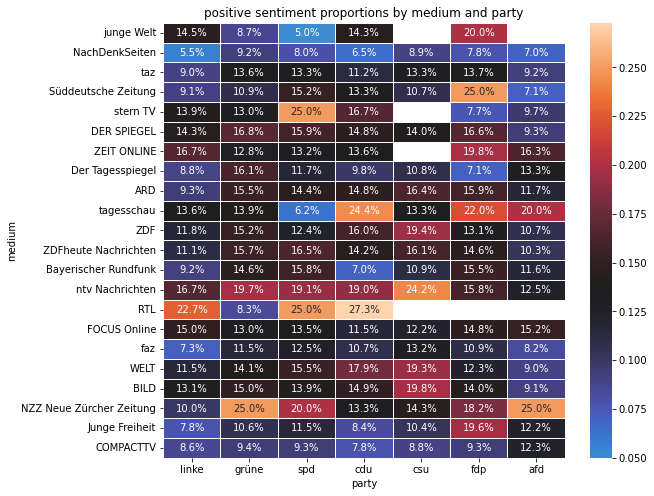

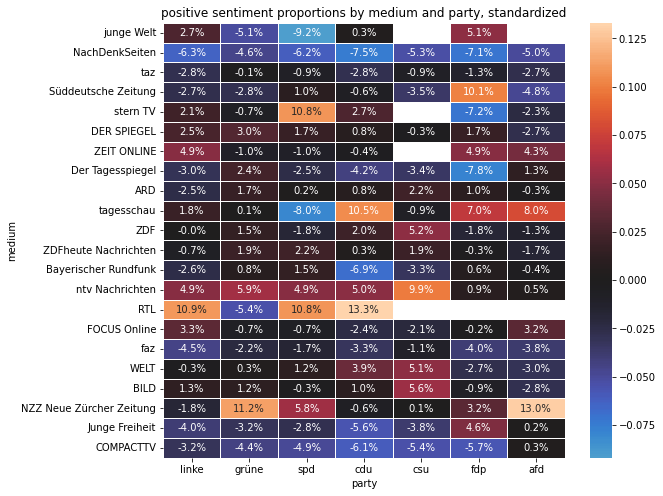

In [59]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        if medium not in temp_df.keys():
            temp_df[medium] = 1
        pos.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)))
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')

In [60]:
print(f"positive sentiment means:\n{pos.mean()}\n\npositive sentiment standard deviation:\n{pos.std()}")

positive sentiment means:
linke    0.117921
grüne    0.137566
spd      0.142289
cdu      0.139799
csu      0.142261
fdp      0.149397
afd      0.119910
dtype: float64

positive sentiment standard deviation:
linke    0.039502
grüne    0.038267
spd      0.050525
cdu      0.051500
csu      0.042325
fdp      0.048090
afd      0.044071
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium and party, standardized')]

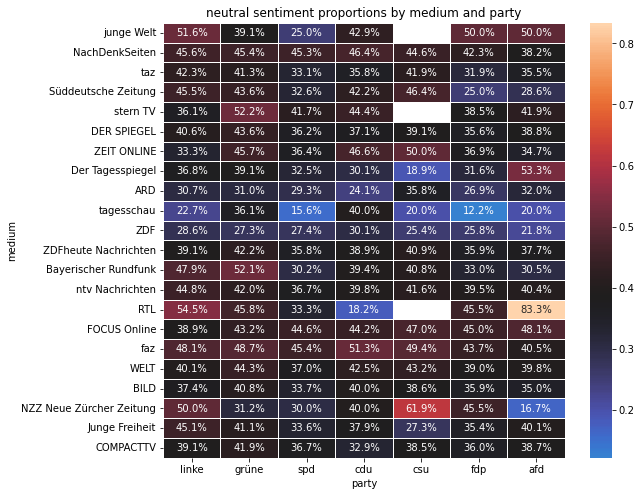

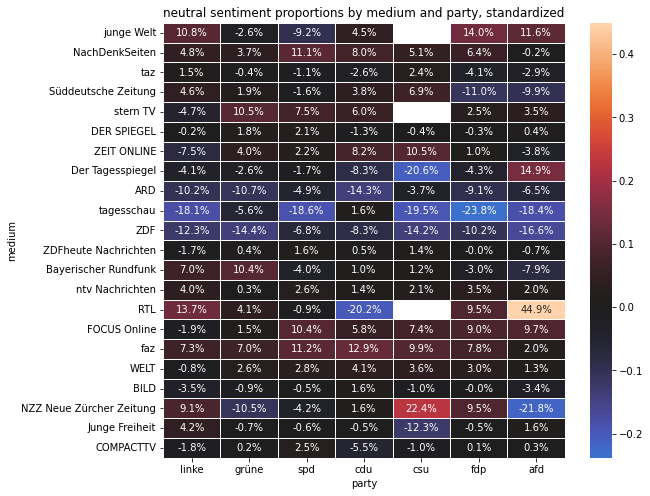

In [61]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        if medium not in temp_df.keys():
            temp_df[medium] = 1
        neu.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)))
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')

In [62]:
print(f"neutral sentiment means:\n{neu.mean()}\n\nneutral sentiment standard deviation:\n{neu.std()}")

neutral sentiment means:
linke    0.408565
grüne    0.417228
spd      0.341880
cdu      0.384042
csu      0.395452
fdp      0.359604
afd      0.384455
dtype: float64

neutral sentiment standard deviation:
linke    0.077788
grüne    0.061955
spd      0.068509
cdu      0.076277
csu      0.106359
fdp      0.084610
afd      0.134792
dtype: float64


[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium and party, standardized')]

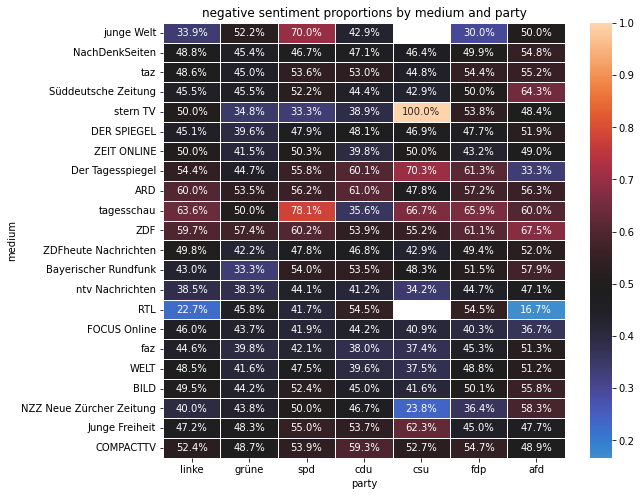

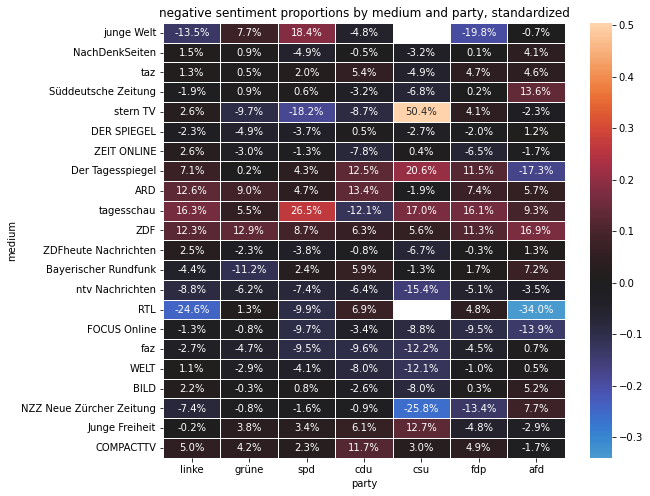

In [63]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        if medium not in temp_df.keys():
            temp_df[medium] = 1
        neg.loc[medium, party] /= temp_df[medium]

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)))
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')

In [64]:
print(f"negative sentiment means:\n{neg.mean()}\n\nnegative sentiment standard deviation:\n{neg.std()}")

negative sentiment means:
linke    0.473514
grüne    0.445207
spd      0.515832
cdu      0.476158
csu      0.496285
fdp      0.497790
afd      0.506536
dtype: float64

negative sentiment standard deviation:
linke    0.088356
grüne    0.057763
spd      0.095887
cdu      0.075467
csu      0.161141
fdp      0.082825
afd      0.108038
dtype: float64


In [68]:
for sentiment, dataframe in dict(zip(['pos', 'neu', 'neg'],[pos, neu, neg])).items():
    export_df = dataframe.copy(deep=True)
    export_df = dataframe.loc[media].drop('tagesschau')[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
    export_df.to_pickle(f'../data/sentiment/{sentiment}.pkl')

    export_df_mwf = dataframe.copy(deep=True)
    export_df_mwf = standardize_df(dataframe).loc[media].drop('tagesschau')[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
    export_df_mwf.to_pickle(f'../data/sentiment/{sentiment}_mittelwertfrei.pkl')

In [71]:
for party in search_terms.keys():
    mention_df = extract_mention_df(party)
    sentiment_df = extract_sentiment_df(mention_df)
    sentiment_df['party'] = party
    sentiment_df.to_pickle(f'../data/sentiment/sentiment_{party}.pkl')

  7%|▋         | 2141/28913 [01:57<24:20, 18.33it/s]

In [4]:
sent_df = pd.DataFrame()
for party in search_terms.keys():
    temp_df = pd.read_pickle(f'../data/sentiment/sentiment_{party}.pkl')
    sent_df = pd.concat([sent_df, temp_df])

In [11]:
party_sample_df = pd.DataFrame()
for party in search_terms.keys():
    temp_df = sent_df[sent_df['party'] == party].sample(n=5, random_state=42)
    party_sample_df = pd.concat([party_sample_df, temp_df])

In [12]:
medium_sample_df = pd.DataFrame()
for medium in media:
    temp_df = sent_df[sent_df['medium'] == medium].sample(n=5, random_state=42)
    medium_sample_df = pd.concat([medium_sample_df, temp_df])

In [27]:
(sent_df.transcript.apply(lambda x: len(x.split())) < 20).value_counts()

False    138915
True      22642
Name: transcript, dtype: int64

In [ ]:
# 100 samples für jeden suchbegriff

In [ ]:
# 100 samples von transcripts